### HVE-WMP decomposition

### Decompose temperature into isopycnal heaving and WMP changes
Based on Bindoff and XY (YYYY), used in several papers by Dotto et al. 
Basic concept: Any change in temperature is due to displacement of isopycnals or due to changes along isopycnals. Quantifying these contributions can give insight into the respective forcing mechanisms. 
To disentangle the two we need to bin temperature into density space following the cosima recipe at: https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/Binning_transformation_from_depth_to_potential_density.ipynb 


In [2]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cf_xarray
import cartopy.crs as ccrs
import cmocean as cm
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
from dask.distributed import Client
import matplotlib.path as mpath
import scipy as sp
import scipy.interpolate
import scipy.ndimage
import scipy.io
import scipy.stats
import pandas as pd
from pandas import DataFrame
import cartopy.feature as cft
from metpy.interpolate import cross_section
from pathlib import Path
import xgcm
from pyproj import Proj, transform
import gsw
from xhistogram.xarray import histogram

In [3]:
client = Client(n_workers=8)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34167/status,
Dashboard: /proxy/34167/status,Workers: 8
Total threads: 16,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46287,Workers: 8
Dashboard: /proxy/34167/status,Total threads: 16
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:38521,Total threads: 2
Dashboard: /proxy/44609/status,Memory: 15.65 GiB
Nanny: tcp://127.0.0.1:39667,


In [4]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [5]:
# This function does the rebinning into bins defined, weighted by defined weights. 
def weighted_rebin(data,rebin_info,bins,dim, weight,dimname):
    output = (histogram(rebin_info, 
                          bins = [bins], 
                          dim = [dim],
                          weights = data*weight)/histogram(rebin_info, 
                          bins = [bins], 
                          dim = [dim],
                          weights = weight)).rename({rebin_info.name + '_bin': dimname}) # rename vertical dimension
    return output

In [6]:
experiment = '01deg_jra55v140_iaf_cycle2'

lat_range = slice(-78, -72)
lon_range = slice(-125,-90)

In [29]:
# Calculate the terms on the large scale: Calculate annual
# We want to calculate HVE and WMP of temperature but using potential density referenced to 250dbar. Since this is not saved we need to calculate it manually. We need to load salinity for that , too. 
start_t = '2004-01-01 00:00:00' # start date, 
end_t = '2006-01-01 00:00:00' # end date
latrange = slice(-76,-70)
lonrange = slice(-111,-99)
strange = slice(0,1000)
t = cc.querying.getvar(experiment, 'temp', session, frequency = '1 monthly',
                       start_time=start_t, end_time=end_t).sel(yt_ocean=latrange).sel(xt_ocean = lonrange).sel(st_ocean=strange).sel(time=slice(start_t,end_t))-273.15
area_t = cc.querying.getvar(experiment,'area_t',session, n=-1).sel(yt_ocean=latrange).sel(xt_ocean = lonrange).fillna(1.0).astype(int) - 1
area_t = area_t.load()

salt = cc.querying.getvar(experiment, 'salt', session,start_time=start_t, frequency = '1 monthly',
                            end_time=end_t).sel(yt_ocean=latrange).sel(xt_ocean = lonrange).sel(st_ocean=strange).sel(time=slice(start_t,end_t))
sa = gsw.conversions.SA_from_SP(salt, salt.st_ocean, salt.xt_ocean, salt.yt_ocean)

rho250 = gsw.density.rho(sa, t, 250).rename('rho250') # Calculates potential density


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:270: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:270: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:270: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3

In [30]:
# Define bins for rebinning! Make sure bins cover the entire density range and have sufficient resolution. In the Amundsen Sea it's mostly between 1028.8 and 1029 kg/m3, so this seems to be a good definition for bins but I have not done much sensitivity testing. 

targetbins250 = np.concatenate((np.arange(1026.5,1028,.02),np.arange(1028,1028.8,.01),np.arange(1028.8,1029.1,.002)),axis=0) # define targetbins as np-array
targetbins250 = xr.DataArray(data = targetbins250, dims='potrho',coords=dict(targetbins250=(['potrho'], targetbins250))) # transform to xarray, necessary for xhistogram
targetbins250 = targetbins250.rename('targetbins250')

# Define bins in depth space for rebinning. I define it by the means between two depth levels. 

st_ocean_bins = np.concatenate(([0],(t.st_ocean.values[1:]+t.st_ocean.values[:-1])/2,[6000]),axis=0)

Calculation: 

dTheta/dt (depth space) = dTheta/dt (density space) - dz/dt (density space) * dTheta/dz (density space, time mean)

In [31]:
# Calculations: 
dtdz = t.mean('time').differentiate('st_ocean') # average temperature gradient

# rebin to density space:
# rename variables (the histogram function wants the same names)
t = t.rename('t')
dtdz = dtdz.rename('dtdz')
pot_rho = rho250.rename('pot_rho')

# Rebin, rename again, and interpolate gaps
dtdz_on_rho = weighted_rebin(dtdz,rebin_info = pot_rho,bins=targetbins250.values,dim='st_ocean', weight=dtdz.st_ocean,dimname='rho')
dtdz_on_rho = dtdz_on_rho.rename('dtdz_on_rho')
dtdz_on_rho = dtdz_on_rho.where(np.isfinite(dtdz_on_rho)).interpolate_na(dim="rho") # empty density classes are filled by linear interpolation

# Temperature 
t_on_rho = weighted_rebin(t,rebin_info = pot_rho,bins=targetbins250.values,dim='st_ocean', weight=t.st_ocean,dimname='rho')
t_on_rho = t_on_rho.rename('t_on_rho')
t_on_rho = t_on_rho.where(np.isfinite(t_on_rho)).interpolate_na(dim="rho")

# st ocean
st_on_rho = weighted_rebin(t.st_ocean,rebin_info = pot_rho,bins=targetbins250.values,dim='st_ocean', weight=t.st_ocean,dimname='rho')
st_on_rho = st_on_rho.rename('st_on_rho')
st_on_rho = st_on_rho.where(np.isfinite(st_on_rho)).interpolate_na(dim="rho")

# Calculate terms and rename
HVE_on_rho = (st_on_rho - st_on_rho.mean('time'))*dtdz_on_rho # HVE on density space defined as vertical displacement of isopycnals * background T gradient
HVE_on_rho = HVE_on_rho.rename('HVE_on_rho')

WMP_on_rho = t_on_rho - t_on_rho.mean('time') # WMP: Simply temperature anomalies on isopycnals
WMP_on_rho = WMP_on_rho.rename('WMP_on_rho')

# Rebin to depth space
HVE = weighted_rebin(HVE_on_rho,rebin_info = st_on_rho,bins=st_ocean_bins,dim='rho', weight=HVE_on_rho.rho,dimname='st_ocean')
HVE = HVE.rename('HVE')
HVE = HVE.where(np.isfinite(HVE)).interpolate_na(dim="st_ocean")
HVE = HVE.assign_coords(st_ocean=t.st_ocean) # Make sure vertical coordinates are the same as before transformation into density space

WMP = weighted_rebin(WMP_on_rho,rebin_info = st_on_rho,bins=st_ocean_bins,dim='rho', weight=WMP_on_rho.rho,dimname='st_ocean')
WMP = WMP.rename('WMP')
WMP = WMP.where(np.isfinite(WMP)).interpolate_na(dim="st_ocean")
WMP = WMP.assign_coords(st_ocean=t.st_ocean)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
 

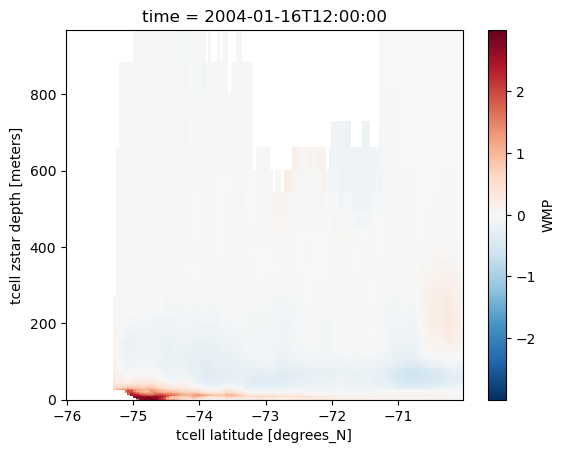

In [32]:
WMP.mean('xt_ocean')[0,:,:].plot(x='yt_ocean')

In [33]:
# Calculate a test decomposition for PIG box: HVE+WMP should be equal to original temperature (small errors introduced by rebinning, interpolation and using background temperature gradient, errors assumed to grow away from reference density)
hve_pig = HVE.sel(xt_ocean = slice(-103.5,-101.5)).sel(yt_ocean = slice(-75.2,-74.5)).sel(st_ocean = slice(100,400)).weighted(HVE.st_ocean*area_t).mean({'xt_ocean','yt_ocean','st_ocean'})
wmp_pig = WMP.sel(xt_ocean = slice(-103.5,-101.5)).sel(yt_ocean = slice(-75.2,-74.5)).sel(st_ocean = slice(100,400)).weighted(WMP.st_ocean*area_t).mean({'xt_ocean','yt_ocean','st_ocean'})
ts_pig = t.sel(xt_ocean = slice(-103.5,-101.5)).sel(yt_ocean = slice(-75.2,-74.5)).sel(st_ocean = slice(100,400)).weighted(t.st_ocean*area_t).mean({'xt_ocean','yt_ocean','st_ocean'})


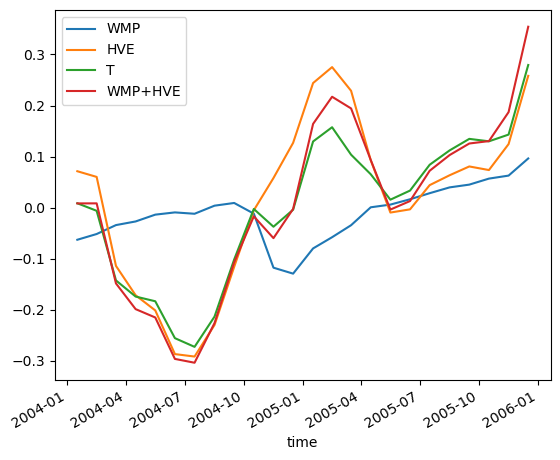

In [34]:
ax = plt.axes()
wmp_pig.plot(ax=ax, label='WMP')
(-hve_pig).plot(ax=ax, label='HVE') # Note minus as I have defined HVE as positive before (can change that in calculations)
(ts_pig-ts_pig.mean('time')).plot(ax=ax, label='T')
(wmp_pig-hve_pig).plot(ax=ax, label='WMP+HVE')
ax.legend()

In [ ]:
%%time
#HVE = HVE.load()
#WMP = WMP.load()

# save variables: Uncomment if desired 
#f='/g/data/jk72/or6852/ensoant/t_hve_rho250_cycle2_8401to1812.nc'
#HVE.to_dataset(name='HVE').to_netcdf(f) # save to file
#f='/g/data/jk72/or6852/ensoant/t_wmp_rho250_cycle2_8401to1812.nc'
#WMP.to_dataset(name='WMP').to_netcdf(f) # save to file